In [13]:
import numpy as np
from scipy import linalg

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
reg_covar = 1e-6
tol = 1e-3
def estimate_gaussian_covariances(resp, X, nk, means, reg_covar):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[::n_features + 1] += reg_covar
    return covariances
def compute_precision(covariances):
    n_components, n_features, _ = covariances.shape
    precisions = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(covariances):
        try:
            cov = linalg.cholesky(covariance, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions[k] = linalg.solve_triangular(cov, np.eye(n_features), lower=True).T
    return precisions
def estimate_gaussian_parameters(X, resp, reg_covar):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    covariances =  estimate_gaussian_covariances(resp, X, nk, means, reg_covar)
    return nk, means, covariances
def logsumexp(arr, axis=0):
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    out = np.log(np.sum(np.exp(arr - vmax), axis=0))
    out += vmax
    return out
def _compute_log_det(matrix,  n_features):

    n_components, _, _ = matrix.shape
    log_det = (np.sum(np.log(matrix.reshape(n_components, -1)[:, ::n_features + 1]), 1))

    return log_det

def _estimate_log_prob(X, means, precisions):
    n_samples, n_features = X.shape
    n_components, _ = means.shape
    # det(precision_chol) is half of det(precision)
    log_det = _compute_log_det(precisions, n_features)

    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions)):
        y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
        log_prob[:, k] = np.sum(np.square(y), axis=1)
    return -.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det

def _estimate_weighted_log_prob( X, means, precisions, weights):
    return _estimate_log_prob(X, means, precisions) + np.log(weights)

def _estimate_log_prob_resp( X, means, precisions, weights):
    weighted_log_prob = _estimate_weighted_log_prob(X, means, precisions, weights)
    log_prob_norm = logsumexp(weighted_log_prob, axis=1)
    with np.errstate(under='ignore'):
        # ignore underflow
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
    return log_prob_norm, log_resp

def _e_step( X, means, precision, weights):
    log_prob_norm, log_resp = _estimate_log_prob_resp(X, means, precision, weights)
    return np.mean(log_prob_norm), log_resp
def _m_step( X, log_resp, means, precisions, weights, covariances, reg_covar):
    n_samples, _ = X.shape
    weights, means, covariances = (estimate_gaussian_parameters(X, np.exp(log_resp),reg_covar))
    weights /= n_samples
    precisions1 = compute_precision(covariances)

    # Attributes computation
    _, n_features = means.shape

    precisions_ = np.empty(precisions1.shape)
    for k, prec in enumerate(precisions1):
        precisions_[k] = np.dot(prec, prec.T)
        
    return weights, means, covariances, precisions
def initialize_parameters(X, random_state, k):
    n_samples, _ = X.shape

    resp = np.random.mtrand._rand.rand(n_samples, k)
    resp /= resp.sum(axis=1)[:, np.newaxis]

    weights, means, covariances = estimate_gaussian_parameters(X, resp, reg_covar)
    weights /= n_samples

    precisions = compute_precision(covariances)
    
    return weights, means, covariances, precisions
def gmm(X, k, max_iter = 100):
    predict = []
    means = []
    covariances = []

    
    
    max_lower_bound = -np.infty
    converged_ = False

    random_state = None #check_random_state(random_state)

    n_samples, _ = X.shape
    
    
    weights, means, covariances, precisions = initialize_parameters(X, random_state, k)
    lower_bound_ = -np.infty

    for n_iter in range(max_iter):
        prev_lower_bound = lower_bound_

        log_prob_norm, log_resp = _e_step(X, means, precisions, weights)
        weights, means, covarainces, precisions = _m_step(X, log_resp, means, precisions, weights, covariances, reg_covar)
        lower_bound_ =  log_prob_norm

        change = lower_bound_ - prev_lower_bound

        if abs(change) < tol:
            converged_ = True
            break
        
    predict = _estimate_weighted_log_prob(X, means, precisions, weights).argmax(axis=1)
    return predict, means, covariances

In [29]:
import scipy.io as sio
data = sio.loadmat('q3.mat')['Xtest']
#print data.shape
#plt.scatter(data[:,0], data[:,1])

predict, means, covariances = gmm(data, k = 3)

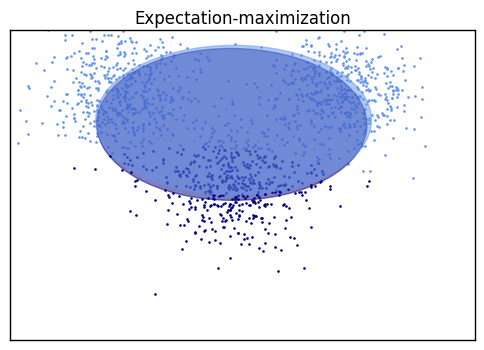

In [34]:
import itertools
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    

plot_results(data, predict, means, covariances, 0,
             'Expectation-maximization')

In [35]:
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',
                              max_iter=100).fit(data)
predict = gmm.predict(data)
means = gmm.means_
covariances = gmm.covariances_